In [1]:
# loading libraries
%load_ext autoreload
%autoreload 2
import sys, os, re
from collections import Counter
import pandas as pd
import numpy as np
sys.path.append(os.path.abspath('../Code'))
from helpers import cumulative_fraction, grams, transpose_note_list
from plot_helpers import *
#from expand_labels import expand_labels, SliceMaker, fifths2name
from ms3.utils import load_tsv, fifths2name, fifths2name, fifths2pc
from ms3.expand_dcml import SM
from ms3 import Parse
#from harmony import regex
#REGEX = re.compile(regex, re.VERBOSE)
from plotly.subplots import make_subplots
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [2]:
# Helper functions
                                     
def plot_cum(S=None, cum=None, x_log=False, markersize=2, left_range=(-0.1, 4.40), right_range=(-0.023,1.099), **kwargs):
    """Pass either a Series or cumulative_fraction(S).reset_index()"""
    if cum is None:
        cum = cumulative_fraction(S).reset_index()
        cum.index = cum.index + 1
    fig = make_subplots(specs=[[{"secondary_y": True,}]])
    ix = cum.index
    fig.add_trace(
        go.Scatter(x=ix, y=cum.x, text=cum['index'], name="Absolute count", mode='markers', marker=dict(size=markersize)),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=ix, y=cum.y, text=cum['index'], name="Cumulative fraction", mode='markers', marker=dict(size=markersize)),
        secondary_y=True,
    )
    fig.update_xaxes(title_text="Rank of chord label", zeroline=False, gridcolor='lightgrey')
    if x_log:
        ranks = np.log(len(ix))/np.log(10)
        fig.update_xaxes(type='log', range=(-0.01*ranks, 1.01*ranks))
    else:
        ranks = len(ix)
        fig.update_xaxes(range=(-0.02*ranks, 1.02*ranks))
    fig.update_yaxes(title_text="Absolute label count", secondary_y=False, type='log', gridcolor='grey', zeroline=True, dtick=1, range=left_range)
    fig.update_yaxes(title_text="Cumulative fraction", secondary_y=True, gridcolor='lightgrey', zeroline=False, dtick=0.1, range=right_range)
    fig.update_layout(**kwargs)
    return fig

def transition_matrix(l=None, gs=None, n=2, k=None, smooth=0, normalize=False, IC=False, filt=None, dist_only=False,sort=False, decimals=2):
    """Returns a transition table from a list of symbols.

    Column index is the last item of grams, row index the n-1 preceding items.

    Parameters
    ----------

    l: list, optional
        List of elements between which the transitions are calculated.
        List can be nested.
    gs: list, optional
        List of tuples being n-grams
    n: int, optional
        get n-grams
    k: int, optional
        Number of rows and columns that you want to keep
    smooth: number, optional
        initial count value of all transitions
    normalize: bool, optional
        set True to divide every row by the sum of the row.
    IC: bool, optional
        Set True to calculate information content.
    filt: list, optional
        elements you want to exclude from the table. All ngrams containing at least one
        of the elements will be filtered out.
    dist_only: bool, optional
        if True, n-grams consisting only of identical elements are filtered out
    """
    if gs is None:
        assert (n>0), f"Cannot print {n}-grams"
        gs = grams(l, n=n)
    elif l is not None:
        assert True, "Specify either l or gs, not both."

    if filt:
        gs = list(filter(lambda n: not any(g in filt for g in n),gs))
    if dist_only:
        gs = list(filter(lambda tup: any(e != tup[0] for e in tup),gs))
    ngrams = pd.Series(gs).value_counts()
    ngrams.index = [(' '.join(t[:-1]),t[-1]) for t in ngrams.index.tolist()]
    context = pd.Index(set([ix[0] for ix in ngrams.index]))
    consequent = pd.Index(set([ix[1] for ix in ngrams.index]))
    df = pd.DataFrame(smooth, index=context, columns=consequent)


    for i, (cont, cons) in enumerate(ngrams.index):
        try:
            df.loc[cont, cons] += ngrams[i]
        except:
            continue



    if k is not None:
        sort=True

    if sort:
        h_sort = list(df.max().sort_values(ascending= False).index.values)
        v_sort = list(df.max(axis=1).sort_values(ascending= False).index.values)
        df = df[h_sort].loc[v_sort]

    SU = df.sum(axis=1)
    if normalize or IC:
        df = df.div(SU,axis=0)

    if IC:
        ic = np.log2(1/df)
        ic['entropy'] = (ic * df).sum(axis=1)
        ############## Identical calucations:
        #ic['entropy2'] = scipy.stats.entropy(df.transpose(),base=2)
        #ic['entropy3'] = -(df * np.log2(df)).sum(axis=1)
        df = ic
        if normalize:
            df['entropy'] = df['entropy'] / np.log2(len(df.columns)-1)
    else:
        df['total'] = SU

    if k is not None:
        df = df.iloc[:k, :k]

    if decimals is not None:
        df = df.round(decimals)

    return df

# Use ms3 to parse the expanded harmony TSVs

In [3]:
p = Parse('.',  file_re='tsv$', exclude_re='AN.tsv$', index='fname', folder_re='harmonies')
p

93 files.
KEY                                 -> EXTENSIONS
-------------------------------------------------
Couperin-gouts_reunis/harmonies     -> {'.tsv': 58}
Couperin-L'art_de_toucher/harmonies -> {'.tsv': 9}
Couperin-concerts_royaux/harmonies  -> {'.tsv': 26}

In [4]:
{key: [t[0] for t in ix] for key, ix in p.index(per_key=True).items()}

{'Couperin-gouts_reunis/harmonies': ['c05n01_prelude',
  'c05n02_allemande',
  'c05n03_sarabande',
  'c05n04_gavote',
  'c05n05_musete',
  'c06n01_grave',
  'c06n02_allemande',
  'c06n03_sarabande',
  'c06n04_air_diable',
  'c06n05_siciliene',
  'c07n01_grave',
  'c07n02_allemande',
  'c07n03_sarabande',
  'c07n04_fuguete',
  'c07n05_gavote',
  'c07n06_siciliene',
  'c08n01_ouverture',
  'c08n02_ritournele',
  'c08n03_air',
  'c08n04_air_tendre',
  'c08n05_air_leger',
  'c08n06_Loure',
  'c08n07_air',
  'c08n08_sarabande',
  'c08n09_air_leger',
  'c08n10_air_lentement',
  'c08n11_air_baccantes',
  'c09n01_charme',
  'c09n02_lenjouement',
  'c09n03_graces',
  'c09n04_Lejene',
  'c09n05_vivacite',
  'c09n06_Sarabande',
  'c09n07_douceur',
  'c09n08_caetera',
  'c10n01_gravement',
  'c10n02_air',
  'c10n03_plainte',
  'c10n04_tromba',
  'c11n01_majestueusement',
  'c11n02_allemande',
  'c11n03_seconde_allemande',
  'c11n04_courante',
  'c11n05_seconde_courante',
  'c11n06_sarabande',
  'c

In [5]:
p = Parse('.', key='coup', exclude_re='AN.tsv$', file_re='tsv$', index='fname', folder_re='harmonies')
p.parse_tsv()
p

93 files.
KEY  -> EXTENSIONS
------------------
coup -> {'.tsv': 93}

All 93 tabular files have been parsed, 93 of them as Annotations object(s).
KEY  -> ANNOTATION LAYERS
-------------------------
coup -> staff  voice  label_type
     -> 1      1      3             9217
     ->        2      3               17
     -> 2      1      3                3
     -> 1      1      0               14

In [6]:
df = p.get_labels()
df['key_regions'] = df.groupby(level=0).localkey.apply(lambda col: col != col.shift()).cumsum()
df.head(20)

mc  mn mc_onset mn_onset timesig  staff  voice    label  \
fname                                                                      
00_allemande 0    1   0        0     5/16     4/4      1      1     .d.V   
             1    1   0     3/16      1/2     4/4      1      1       i6   
             2    1   0     7/16      3/4     4/4      1      1        i   
             3    2   1        0        0     4/4      1      1       V6   
             4    2   1      1/4      1/4     4/4      1      1        V   
             5    2   1      1/2      1/2     4/4      1      1     IV65   
             6    2   1      3/4      3/4     4/4      1      1       V7   
             7    3   2        0        0     4/4      1      1       i6   
             8    3   2      1/4      1/4     4/4      1      1      i\\   
             9    3   2      3/8      3/8     4/4      1      1      VI6   
             10   3   2      1/2      1/2     4/4      1      1      iio   
             11   3   2      5/8      5/8     4/4      1      1      VI6   
             12   3   2      3/4      3/4     4/4      1      1   V7/III   
             13   4   3        0        0     4/4      1      1    III\\   
             14   4   3      1/4      1/4     4/4      1      1      V64   
             15   4   3      1/2      1/2     4/4      1      1        i   
             16   4   3      3/4      3/4     4/4      1      1  v.iio64   
             17   4   3      7/8      7/8     4/4      1      1       iv   
             18   5   4        0        0     4/4      1      1        V   
             19   5   4      1/4      1/4     4/4      1      1     V/iv   

                alt_label globalkey localkey pedal   chord numeral form  \
fname                                                                     
00_allemande 0        NaN         d        i   NaN       V       V  NaN   
             1        NaN         d        i   NaN      i6       i  NaN   
             2        NaN         d        i   NaN       i       i  NaN   
             3        NaN         d        i   NaN      V6       V  NaN   
             4        NaN         d        i   NaN       V       V  NaN   
             5        NaN         d        i   NaN    IV65      IV  NaN   
             6        NaN         d        i   NaN      V7       V  NaN   
             7        NaN         d        i   NaN      i6       i  NaN   
             8        NaN         d        i   NaN       i       i  NaN   
             9        NaN         d        i   NaN     VI6      VI  NaN   
             10       NaN         d        i   NaN     iio      ii    o   
             11       NaN         d        i   NaN     VI6      VI  NaN   
             12       NaN         d        i   NaN  V7/III       V  NaN   
             13       NaN         d        i   NaN     III     III  NaN   
             14       NaN         d        i   NaN     V64       V  NaN   
             15       NaN         d        i   NaN       i       i  NaN   
             16       NaN         d        v   NaN   iio64      ii    o   
             17       NaN         d        v   NaN      iv      iv  NaN   
             18       NaN         d        v   NaN       V       V  NaN   
             19       NaN         d        v   NaN    V/iv       V  NaN   

                figbass changes relativeroot phraseend chord_type  \
fname                                                               
00_allemande 0      NaN     NaN          NaN       NaN          M   
             1        6     NaN          NaN       NaN          m   
             2      NaN     NaN          NaN       NaN          m   
             3        6     NaN          NaN       NaN          M   
             4      NaN     NaN          NaN       NaN          M   
             5       65     NaN          NaN       NaN        Mm7   
             6        7     NaN          NaN       NaN        Mm7   
             7        6     NaN          NaN       NaN          m   
   

In [7]:
df.index.is_unique

True

# Unigrams

In [8]:
k = 25
df.chord.value_counts().iloc[:k]

V        1256
I        1057
i         823
V7        471
V65       468
I6        445
i6        403
V43       309
ii%65     238
IV        230
V2        185
ii65      177
V6        159
V(4)      145
ii        134
vi        132
ii%43     127
iv        126
IV6       109
V(64)      93
iv6        83
ii7        78
i64        67
v6         65
ii6        65
Name: chord, dtype: int64

In [9]:
STD_LAYOUT

{'paper_bgcolor': '#FFFFFF',
 'plot_bgcolor': '#FFFFFF',
 'margin': {'l': 40, 'r': 0, 'b': 0, 't': 0, 'pad': 0}}

In [10]:
font_dict = {'font': {'size': 20}}
STD_LAYOUT.update(font_dict)
H_LAYOUT = STD_LAYOUT.copy()
H_LAYOUT.update({'legend': dict({'orientation': 'h', 'itemsizing':'constant', 'x': -0.05}, **font_dict)})

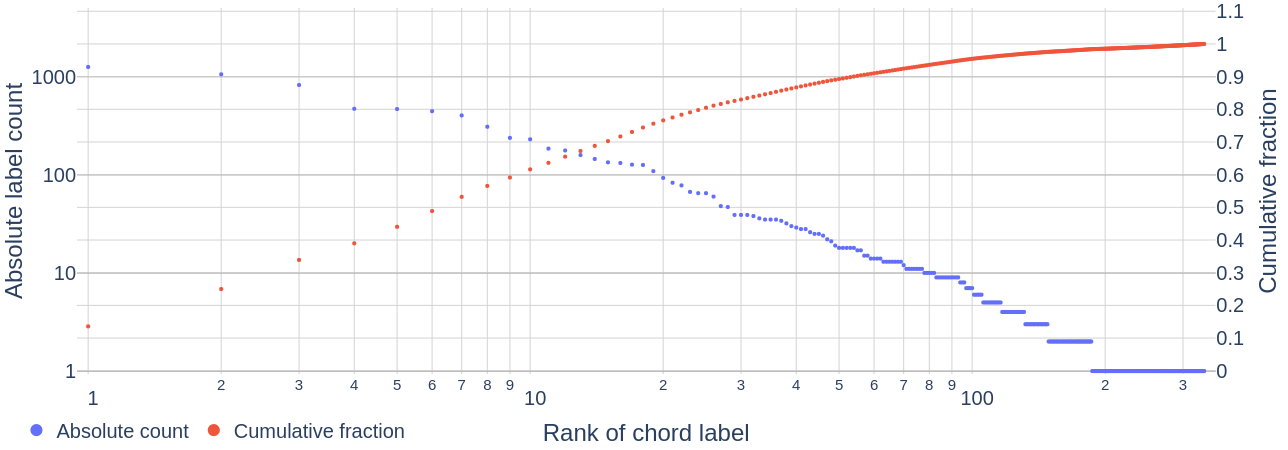

In [11]:
fig = plot_cum(df.chord, x_log=True, markersize=4, left_range=(-0.03, 3.7), right_range=(-0.01,1.11), **H_LAYOUT)
store(fig, 'type_distribution.eps', height=400)
#fig.show()

In [12]:
df.chord.value_counts().iloc[:k]

V        1256
I        1057
i         823
V7        471
V65       468
I6        445
i6        403
V43       309
ii%65     238
IV        230
V2        185
ii65      177
V6        159
V(4)      145
ii        134
vi        132
ii%43     127
iv        126
IV6       109
V(64)      93
iv6        83
ii7        78
i64        67
v6         65
ii6        65
Name: chord, dtype: int64

# Bigrams

In [13]:
chord_successions = [s.to_list() for _, s in df.groupby('key_regions').chord]

In [14]:
gs = grams(chord_successions)
c = Counter(gs)

In [15]:
dict(sorted(c.items(), key=lambda a: a[1], reverse=True)[:k])

{('V', 'I'): 268,
 ('V7', 'I'): 217,
 ('V', 'i'): 208,
 ('I', 'V'): 179,
 ('i', 'V'): 154,
 ('V', 'V7'): 153,
 ('V65', 'I'): 152,
 ('V7', 'i'): 135,
 ('ii%65', 'V'): 126,
 ('V', 'I6'): 125,
 ('V65', 'i'): 118,
 ('V(4)', 'V'): 107,
 ('V65', 'V7'): 107,
 ('I6', 'I'): 89,
 ('ii65', 'V'): 88,
 ('V43', 'i'): 88,
 ('V43', 'I'): 85,
 ('V', 'i6'): 82,
 ('V2', 'i6'): 82,
 ('i6', 'V43'): 79,
 ('I', 'I6'): 78,
 ('V2', 'I6'): 71,
 ('V', 'V2'): 69,
 ('i6', 'ii%65'): 67,
 ('I6', 'V43'): 65}

## Absolute Counts (read from index to column)

In [16]:
transition_matrix(chord_successions, k=k, dist_only=True)

,I,i,V,V7,I6,i6,V43,V2,ii%65,ii65,V65,V6,IV,ii,vi,V(4),ii%43,iv,v6,VI,iii6,iv7,ii7,IVM7,IV6
V,268,208,0,153,125,82,12,69,4,0,50,22,4,13,7,0,9,0,5,1,15,1,0,0,14
V7,217,135,3,0,2,7,1,1,0,0,9,0,0,0,17,0,0,0,0,8,0,0,0,0,2
I,0,6,179,28,78,0,22,8,0,37,48,50,49,2,42,32,0,1,0,0,2,0,3,14,10
i,4,0,154,3,0,55,25,9,38,3,56,15,14,1,0,14,20,10,27,17,0,14,1,0,3
V65,152,118,17,107,2,10,6,3,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0
ii%65,0,10,126,4,0,16,1,7,0,0,2,0,0,0,0,22,5,0,0,0,0,0,2,0,0
V(4),0,0,107,21,1,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,1,0,0,0,0
I6,89,0,31,1,0,0,65,1,0,64,9,9,40,1,17,14,0,0,0,0,0,2,14,4,4
ii65,7,1,88,6,3,0,0,7,0,0,0,0,0,3,0,20,0,0,0,0,1,0,8,0,2
V43,85,88,5,5,26,44,0,2,0,0,28,2,0,0,0,0,0,0,0,0,0,0,0,0,0


## Normalized Counts

In [17]:
transition_matrix(chord_successions, k=k, dist_only=True, normalize=True, decimals=2)

,I,i,V,V7,I6,i6,V43,V2,ii%65,ii65,V65,V6,IV,ii,vi,V(4),ii%43,iv,v6,VI,iii6,iv7,ii7,IVM7,IV6
V,0.22,0.17,0.00,0.13,0.10,0.07,0.01,0.06,0.00,0.00,0.04,0.02,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01
V7,0.47,0.29,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00
I,0.00,0.01,0.24,0.04,0.10,0.00,0.03,0.01,0.00,0.05,0.06,0.07,0.06,0.00,0.06,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01
i,0.01,0.00,0.24,0.00,0.00,0.09,0.04,0.01,0.06,0.00,0.09,0.02,0.02,0.00,0.00,0.02,0.03,0.02,0.04,0.03,0.00,0.02,0.00,0.00,0.00
V65,0.33,0.25,0.04,0.23,0.00,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ii%65,0.00,0.04,0.53,0.02,0.00,0.07,0.00,0.03,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.09,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
V(4),0.00,0.00,0.74,0.14,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
I6,0.20,0.00,0.07,0.00,0.00,0.00,0.15,0.00,0.00,0.15,0.02,0.02,0.09,0.00,0.04,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.01
ii65,0.04,0.01,0.50,0.03,0.02,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.11,0.00,0.00,0.00,0.00,0.01,0.00,0.05,0.00,0.01
V43,0.28,0.28,0.02,0.02,0.08,0.14,0.00,0.01,0.00,0.00,0.09,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Entropy

In [18]:
transition_matrix(chord_successions, k=k, IC=True, dist_only=True, smooth=1, decimals=2)

,I,i,V,V7,I6,i6,V43,V2,ii%65,ii65,V65,V6,IV,ii,vi,V(4),ii%43,iv,v6,VI,iii6,iv7,ii7,IVM7,IV6
V,2.50,2.86,10.57,3.30,3.59,4.20,6.87,4.44,8.25,10.57,4.90,6.05,8.25,6.76,7.57,10.57,7.25,10.57,7.99,9.57,6.57,9.57,10.57,10.57,6.66
V7,1.86,2.54,7.63,9.63,8.04,6.63,8.63,8.63,9.63,9.63,6.31,9.63,9.63,9.63,5.46,9.63,9.63,9.63,9.63,6.46,9.63,9.63,9.63,9.63,8.04
I,10.09,7.28,2.59,5.23,3.78,10.09,5.56,6.92,10.09,4.84,4.47,4.41,4.44,8.50,4.66,5.04,10.09,9.09,10.09,10.09,8.50,10.09,8.09,6.18,6.63
i,7.60,9.92,2.64,7.92,9.92,4.11,5.22,6.60,4.63,7.92,4.09,5.92,6.01,8.92,9.92,6.01,5.53,6.46,5.11,5.75,9.92,6.01,8.92,9.92,7.92
V65,2.38,2.74,5.46,2.88,8.05,6.17,6.83,7.63,9.63,9.63,9.63,8.63,9.63,9.63,8.63,9.63,8.63,9.63,9.63,9.63,9.63,9.63,9.63,9.63,9.63
ii%65,9.15,5.69,2.16,6.83,9.15,5.06,8.15,6.15,9.15,9.15,7.56,9.15,9.15,9.15,9.15,4.62,6.56,9.15,9.15,9.15,9.15,9.15,7.56,9.15,9.15
V(4),8.89,8.89,2.13,4.43,7.89,8.89,8.89,8.89,8.89,8.89,7.89,7.30,8.89,8.89,8.89,8.89,7.89,8.89,8.89,8.89,7.89,8.89,8.89,8.89,8.89
I6,3.09,9.58,4.58,8.58,9.58,9.58,3.54,8.58,9.58,3.56,6.26,6.26,4.23,8.58,5.41,5.68,9.58,9.58,9.58,9.58,9.58,8.00,5.68,7.26,7.26
ii65,5.98,7.98,2.50,6.17,6.98,8.98,8.98,5.98,8.98,8.98,8.98,8.98,8.98,6.98,8.98,4.59,8.98,8.98,8.98,8.98,7.98,8.98,5.81,8.98,7.40
V43,2.89,2.84,6.73,6.73,4.56,3.83,9.32,7.73,9.32,9.32,4.46,7.73,9.32,9.32,9.32,9.32,9.32,9.32,9.32,9.32,9.32,9.32,9.32,9.32,9.32


## Minor vs. Major

In [19]:
region_is_minor = df.groupby('key_regions').localkey_is_minor.unique().map(lambda l: l[0]).to_dict()
region_key = df.groupby('key_regions').localkey.unique().map(lambda l: l[0]).to_dict()

In [20]:
key_chords = {ix: s.to_list() for ix, s in df.reset_index().groupby(['fname', 'key_regions']).chord}
major, minor = [], []
for chords, is_minor in zip(key_chords.values(), region_is_minor.values()):
    (major, minor)[is_minor].append(chords)

In [21]:
transition_matrix(major, k=k, dist_only=True, normalize=True)

,I,V,I6,V7,V43,ii65,V6,IV,V65,vi,ii,V2,V(4),iii6,ii7,IVM7,V43/V,IV64,V(64),ii43,ii2,vi6,I(4),IV6,ii6
V,0.38,0.00,0.20,0.13,0.00,0.00,0.02,0.00,0.04,0.01,0.02,0.05,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00
V7,0.76,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.01,0.01,0.00
I,0.00,0.24,0.10,0.04,0.03,0.05,0.07,0.07,0.06,0.06,0.00,0.01,0.04,0.00,0.00,0.02,0.01,0.02,0.02,0.00,0.01,0.01,0.00,0.01,0.01
V65,0.63,0.03,0.01,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00
I6,0.20,0.07,0.00,0.00,0.15,0.14,0.02,0.09,0.02,0.04,0.00,0.00,0.03,0.00,0.03,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.00
V43,0.61,0.02,0.19,0.02,0.00,0.00,0.01,0.00,0.06,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00
ii65,0.04,0.49,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.04,0.12,0.01,0.05,0.00,0.00,0.00,0.06,0.07,0.00,0.00,0.00,0.01,0.00
V2,0.02,0.00,0.81,0.00,0.04,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
V(4),0.00,0.77,0.01,0.13,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
IV6,0.06,0.05,0.05,0.05,0.01,0.01,0.04,0.06,0.46,0.00,0.04,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.01


In [22]:
transition_matrix(minor, k=k, dist_only=True, normalize=True)

,i,V,i6,V43,V7,ii%65,V65,V2,I,v6,ii%43,iv,V(4),VI,V6,IV,iv7,iv6,i64,V(64),ii,V6/iv,ii%7,III,#viio65
V,0.37,0.00,0.14,0.02,0.12,0.01,0.05,0.07,0.05,0.00,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.02,0.00,0.0,0.00
i,0.00,0.24,0.09,0.04,0.00,0.06,0.09,0.01,0.00,0.04,0.03,0.02,0.02,0.03,0.02,0.02,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.00
V7,0.64,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.11,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.0,0.00
ii%65,0.04,0.52,0.07,0.00,0.02,0.00,0.01,0.03,0.00,0.00,0.02,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.05,0.05,0.00,0.00,0.03,0.0,0.00
V65,0.50,0.05,0.04,0.02,0.24,0.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
V43,0.49,0.01,0.26,0.00,0.01,0.00,0.12,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.00,0.0,0.00
V2,0.04,0.00,0.83,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
i6,0.15,0.05,0.00,0.20,0.00,0.17,0.10,0.01,0.00,0.00,0.01,0.02,0.01,0.02,0.01,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.02,0.0,0.02
ii%43,0.00,0.32,0.04,0.02,0.07,0.35,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.10,0.02,0.00,0.00,0.00,0.0,0.00
V(4),0.00,0.69,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00


## Chord progressions without suspensions

Here called *plain chords*, which consist only of numeral, inversion figures, and relative keys.

In [23]:
df['plain_chords'] = df.numeral + df.figbass.fillna('') + ('/' + df.relativeroot).fillna('')

In [24]:
df.plain_chords.iloc[:k]

fname           
00_allemande  0          V
              1         i6
              2          i
              3         V6
              4          V
              5       IV65
              6         V7
              7         i6
              8          i
              9        VI6
              10        ii
              11       VI6
              12    V7/III
              13       III
              14       V64
              15         i
              16      ii64
              17        iv
              18         V
              19      V/iv
              20    V65/iv
              21     V/VII
              22      VII6
              23        ii
              24       V65
Name: plain_chords, dtype: object

**Consecutive identical labels are merged**

In [25]:
def remove_subsequent_identical(col):
    return col[col != col.shift()].to_list()
key_regions_plain_chords = df.reset_index().groupby(['fname', 'key_regions']).plain_chords.apply(remove_subsequent_identical)
key_plain_chords = {ix: s for ix, s in key_regions_plain_chords.iteritems()}
major_plain, minor_plain = [], []
for chords, is_minor in zip(key_plain_chords.values(), region_is_minor.values()):
    (major_plain, minor_plain)[is_minor].append(chords)

In [26]:
plain_chords_per_segment = {k: len(v) for k, v in key_plain_chords.items()}

In [27]:
print(f"The local key segments have {sum(plain_chords_per_segment.values())} 'plain chords' without immediate repetitions, \
yielding {len(grams(list(key_plain_chords.values())))} bigrams.\n{sum(map(len, major_plain))} chords are in major, {sum(map(len, minor_plain))} in minor.")

The local key segments have 8766 'plain chords' without immediate repetitions, yielding 8172 bigrams.
4307 chords are in major, 4459 in minor.


In [28]:
{segment: chord_count  for segment, chord_count in list({(piece, region_key[key] + (' minor' if region_is_minor[key] else ' major')): v for (piece, key), v in plain_chords_per_segment.items()}.items())[:k]}

{('00_allemande', 'i minor'): 44,
 ('00_allemande', 'v minor'): 15,
 ('01_premier_prélude_JM', 'I major'): 4,
 ('01_premier_prélude_JM', 'V major'): 5,
 ('01_premier_prélude_JM', 'ii minor'): 2,
 ('02_second_prélude_JM', 'i minor'): 15,
 ('02_second_prélude_JM', 'III major'): 10,
 ('03_troisième_prélude_JM', 'i minor'): 26,
 ('03_troisième_prélude_JM', 'III major'): 14,
 ('03_troisième_prélude_JM', 'v minor'): 16,
 ('04_quatrième_prélude_JM', 'I major'): 13,
 ('04_quatrième_prélude_JM', 'IV major'): 6,
 ('04_quatrième_prélude_JM', 'V major'): 17,
 ('04_quatrième_prélude_JM', 'ii minor'): 4,
 ('05_cinquième_prélude', 'I major'): 14,
 ('05_cinquième_prélude', 'V major'): 20,
 ('05_cinquième_prélude', 'IV major'): 8,
 ('05_cinquième_prélude', 'ii minor'): 27,
 ('06_sixième_prélude', 'i minor'): 34,
 ('06_sixième_prélude', 'III major'): 24,
 ('06_sixième_prélude', 'VII major'): 8,
 ('06_sixième_prélude', 'v minor'): 13,
 ('06_sixième_prélude', 'iv minor'): 7,
 ('07_septième_prélude', 'I ma

In [29]:
from statistics import mean
print(f"Segments being in the same local key have a mean length of {round(mean(plain_chords_per_segment.values()), 2)} plain chords.")

Segments being in the same local key have a mean length of 14.76 plain chords.


### Most frequent 3-, 4-, and 5-grams in major

In [30]:
def sorted_gram_counts(l, n=2, k=k):
    return {t: count for t, count in sorted(Counter(grams(l, n=n)).items(), key=lambda a: a[1], reverse=True)[:k]}

sorted_gram_counts(major_plain, 3)

{('V', 'V7', 'I'): 98,
 ('I', 'V', 'I'): 94,
 ('I6', 'V43', 'I'): 55,
 ('ii65', 'V', 'I'): 55,
 ('V65', 'I', 'V'): 50,
 ('V65', 'V7', 'I'): 44,
 ('V', 'I6', 'I'): 40,
 ('V43', 'I', 'V'): 39,
 ('I6', 'I', 'V'): 36,
 ('ii65', 'V', 'V7'): 36,
 ('V', 'I', 'V'): 35,
 ('I', 'V', 'V7'): 33,
 ('I6', 'ii65', 'V'): 33,
 ('vi', 'ii65', 'V'): 32,
 ('IV6', 'V65', 'I'): 30,
 ('I', 'V', 'I6'): 29,
 ('I', 'V65', 'I'): 29,
 ('V', 'V2', 'I6'): 27,
 ('I', 'ii65', 'V'): 25,
 ('I6', 'V', 'I'): 24,
 ('V65', 'I', 'I6'): 22,
 ('V', 'I', 'I6'): 22,
 ('I', 'I6', 'V'): 20,
 ('V', 'V65', 'I'): 20,
 ('I', 'V7', 'I'): 19}

In [31]:
sorted_gram_counts(major_plain, 4)

{('ii65', 'V', 'V7', 'I'): 34,
 ('I', 'V', 'V7', 'I'): 27,
 ('I6', 'V43', 'I', 'V'): 21,
 ('vi', 'ii65', 'V', 'I'): 21,
 ('V65', 'I', 'V', 'I'): 19,
 ('V', 'I6', 'I', 'V'): 18,
 ('IV', 'I6', 'V43', 'I'): 16,
 ('V43', 'I', 'V', 'I'): 16,
 ('V', 'I6', 'V43', 'I'): 15,
 ('I6', 'ii65', 'V', 'I'): 15,
 ('I6', 'V', 'V7', 'I'): 14,
 ('I6', 'I', 'V', 'I'): 14,
 ('I', 'ii65', 'V', 'I'): 13,
 ('I6', 'ii65', 'V', 'V7'): 12,
 ('IV', 'V43', 'I', 'V'): 12,
 ('I', 'V65', 'I', 'V'): 12,
 ('I', 'V65', 'V7', 'I'): 12,
 ('I', 'V', 'I', 'V'): 12,
 ('V7', 'I', 'V7', 'I'): 12,
 ('V', 'I', 'V', 'I'): 11,
 ('vi', 'ii65', 'V', 'V7'): 10,
 ('V65', 'V7', 'I', 'V65'): 10,
 ('I', 'vi', 'ii65', 'V'): 10,
 ('V7', 'vi', 'ii65', 'V'): 9,
 ('V2', 'I6', 'ii65', 'V'): 9}

In [32]:
sorted_gram_counts(major_plain, 5)

{('I6', 'ii65', 'V', 'V7', 'I'): 11,
 ('I6', 'V43', 'I', 'V', 'I'): 10,
 ('vi', 'ii65', 'V', 'V7', 'I'): 9,
 ('V65', 'V7', 'I', 'V65', 'V7'): 9,
 ('V7', 'I', 'V65', 'V7', 'I'): 9,
 ('I', 'ii65', 'V', 'V7', 'I'): 9,
 ('V', 'I6', 'I', 'V', 'I'): 8,
 ('I', 'V65', 'V7', 'I', 'V65'): 8,
 ('I6', 'I', 'V', 'V7', 'I'): 8,
 ('I', 'V7', 'I', 'V7', 'I'): 8,
 ('V', 'I6', 'I', 'V', 'V7'): 7,
 ('V', 'I', 'V', 'V7', 'I'): 7,
 ('I6', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'IV', 'I6', 'V43', 'I'): 6,
 ('I', 'vi', 'ii65', 'V', 'I'): 6,
 ('I', 'V7', 'vi', 'ii65', 'V'): 6,
 ('I6', 'IV', 'I6', 'V43', 'I'): 6,
 ('IV', 'I6', 'V43', 'I', 'V'): 6,
 ('V65', 'I', 'ii2', 'V65', 'I'): 5,
 ('I', 'I6', 'V', 'V7', 'I'): 5,
 ('V7', 'vi', 'ii65', 'V', 'V7'): 5,
 ('I6', 'IV', 'V43', 'I', 'V'): 5,
 ('V65', 'I', 'V', 'V7', 'I'): 5,
 ('V', 'I6', 'V43', 'I', 'V65'): 5,
 ('V7', 'I', 'V7', 'vi', 'ii65'): 5}

### Most frequent 3-, 4-, and 5-grams in minor

In [33]:
sorted_gram_counts(minor_plain, 3)

{('i', 'V', 'i'): 72,
 ('V', 'V7', 'i'): 58,
 ('ii65', 'V', 'i'): 54,
 ('V65', 'i', 'V'): 53,
 ('i6', 'V43', 'i'): 52,
 ('i6', 'ii65', 'V'): 51,
 ('V65', 'V7', 'i'): 45,
 ('ii65', 'V', 'V7'): 40,
 ('i', 'V65', 'i'): 39,
 ('ii43', 'ii65', 'V'): 37,
 ('V', 'i', 'V'): 35,
 ('V43', 'i', 'V'): 30,
 ('V', 'V2', 'i6'): 28,
 ('i', 'ii65', 'V'): 28,
 ('V2', 'i6', 'V43'): 25,
 ('i6', 'V65', 'i'): 23,
 ('V', 'i6', 'i'): 22,
 ('V43', 'i', 'V65'): 22,
 ('i', 'V', 'V7'): 22,
 ('VI', 'ii65', 'V'): 21,
 ('V', 'i6', 'V43'): 21,
 ('V', 'i', 'V65'): 20,
 ('V', 'V7', 'I'): 19,
 ('V7', 'i', 'V'): 19,
 ('ii65', 'V', 'i6'): 18}

In [34]:
sorted_gram_counts(minor_plain, 4)

{('ii65', 'V', 'V7', 'i'): 29,
 ('V43', 'i', 'V', 'i'): 20,
 ('V2', 'i6', 'V43', 'i'): 18,
 ('i6', 'ii65', 'V', 'i'): 17,
 ('i', 'V65', 'i', 'V'): 17,
 ('i6', 'ii65', 'V', 'V7'): 16,
 ('V65', 'i', 'V', 'i'): 16,
 ('V', 'i', 'V65', 'i'): 16,
 ('V', 'i', 'V', 'i'): 15,
 ('V', 'i6', 'V43', 'i'): 15,
 ('i', 'ii65', 'V', 'i'): 15,
 ('i6', 'V43', 'i', 'V'): 15,
 ('V43', 'i6', 'ii65', 'V'): 13,
 ('V43', 'i', 'V65', 'i'): 13,
 ('i6', 'V43', 'i', 'V65'): 13,
 ('i', 'V', 'V7', 'i'): 13,
 ('ii65', 'V', 'V7', 'I'): 10,
 ('i', 'V', 'i', 'V65'): 10,
 ('i', 'V', 'i', 'V'): 10,
 ('ii65', 'V', 'i6', 'V43'): 10,
 ('VI7', 'ii43', 'ii65', 'V'): 10,
 ('i', 'i6', 'ii65', 'V'): 10,
 ('V2', 'i6', 'ii65', 'V'): 9,
 ('i', 'V65', 'V7', 'i'): 9,
 ('V65', 'V7', 'i', 'V'): 9}

In [35]:
sorted_gram_counts(minor_plain, 5)

{('i6', 'ii65', 'V', 'V7', 'i'): 13,
 ('i6', 'V43', 'i', 'V', 'i'): 13,
 ('i', 'V', 'i', 'V65', 'i'): 10,
 ('V', 'i', 'V65', 'i', 'V'): 9,
 ('ii65', 'V', 'i6', 'V43', 'i'): 9,
 ('V65', 'V7', 'i', 'ii65', 'V'): 8,
 ('V', 'i6', 'V43', 'i', 'V'): 8,
 ('V43', 'i', 'V65', 'i', 'V'): 7,
 ('V65', 'i', 'V', 'i', 'V65'): 7,
 ('VI', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'ii65', 'V', 'V7', 'i'): 6,
 ('i', 'V', 'i', 'V', 'i'): 6,
 ('V65/iv', 'iv', 'ii7', 'ii65', 'V'): 6,
 ('iv', 'ii7', 'ii65', 'V', 'i6'): 6,
 ('ii7', 'ii65', 'V', 'i6', 'V43'): 6,
 ('i6', '#vii65', 'i6', '#vii65', 'i6'): 6,
 ('ii65', 'i6', 'ii65', 'i6', 'ii65'): 6,
 ('i6', 'ii65', 'i6', 'ii65', 'i6'): 6,
 ('V65', 'i', 'i6', 'ii65', 'V'): 6,
 ('i', 'V65', 'i', 'V', 'i'): 6,
 ('i6', 'V43', 'i', 'V65', 'i'): 6,
 ('i6', 'V43', 'i6', 'ii65', 'V'): 5,
 ('ii43', 'ii65', 'V', 'V2', 'i6'): 5,
 ('i', 'V2', 'i6', 'V43', 'i'): 5,
 ('V', 'V2', 'i6', 'V43', 'i'): 5}

## Counting particular progressions

In [36]:
MEMORY = {}
l = list(key_plain_chords.values())
def look_for(n_gram):
    n = len(n_gram)
    if n in MEMORY:
        n_grams = MEMORY[n]
    else:
        n_grams = grams(l, n)
        MEMORY[n] = n_grams
    matches = n_grams.count(n_gram)
    total = len(n_grams)
    return f"{matches} ({round(100*matches/total, 3)} %)"

In [37]:
look_for(('i', 'v6'))

'28 (0.343 %)'

In [38]:
look_for(('i', 'v6', 'iv6'))

'10 (0.132 %)'

In [39]:
look_for(('i', 'v6', 'iv6', 'V'))

'8 (0.114 %)'

In [40]:
look_for(('i', 'V6', 'v6'))

'3 (0.04 %)'

In [41]:
look_for(('V', 'IV6', 'V65'))

'14 (0.185 %)'

## Chord progressions preceding phrase endings

In [42]:
def phraseending_progressions(df, n=3, k=k):
    selector = df.groupby(level=0).phraseend.apply(lambda col: col.notna().shift().fillna(True)).cumsum()
    print(f"{selector.max()} phrases overall.")
    phraseends = df.groupby(selector).apply(lambda df: df.chord.iloc[-n:].reset_index(drop=True)).unstack()
    return phraseends.groupby(phraseends.columns.to_list()).size().sort_values(ascending=False).iloc[:k]

In [43]:
phraseending_progressions(df)

737 phrases overall.


0      1      2
V      V7     I    71
V(4)   V      I    48
V      V7     i    42
I      V      I    29
V(64)  V      I    27
ii65   V      I    24
V(4)   V      i    23
i      V      i    21
ii%65  V      i    20
V65    i      V    16
V(64)  V      i    15
V(4)   V7     I    12
V65    I      V    12
V43    I      V    12
V      i      V     9
V7     i      V     9
ii%65  V      I     9
V43    i      V     8
i(4)   i      V     7
V(4)   V7     i     6
VIM7   ii%43  V     6
I6     V43    I     6
V(64)  V7     I     6
ii%43  ii%65  V     5
ii65   ii43   V     5
dtype: int64

In [44]:
phraseending_progressions(df, 4)

737 phrases overall.


0      1      2    3
ii65   V      V7   I    23
ii%65  V      V7   i    19
I      V      V7   I    15
ii65   V(4)   V    I    15
I      V(4)   V    I    14
i      V      V7   i    12
vi     ii65   V    I    12
ii%65  V(4)   V    i    11
V43    i      V    i    10
       I      V    I    10
I6     V      V7   I     9
i      V(4)   V    i     8
I6     V(4)   V    I     7
i      ii%65  V    i     7
I      ii65   V    I     7
ii%65  V(64)  V    i     7
       V      V7   I     6
IV     V43    I    V     6
I6     V(64)  V    I     6
I      V(64)  V    I     6
i      V      V7   I     5
V65    i(4)   i    V     5
I6     V43    I    V     5
IV     I6     V43  I     5
V(64)  V      V7   I     5
dtype: int64